In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0. 

In [71]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)

In [72]:
df.describe()

,hectares_ha,production_tonnes,year,yield_tonnes_ha
count,3.415500e+04,3.415500e+04,34155.000000,34155.000000
mean,6.745161e+05,1.634547e+06,1956.119836,2.679773
std,1.616353e+06,5.003067e+06,38.730405,2.239175
min,1.000000e+00,0.000000e+00,1861.000000,0.000000
25%,3.642120e+04,7.022915e+04,1927.000000,1.137703
50%,1.800826e+05,3.302174e+05,1959.000000,1.881500
75%,6.426318e+05,1.243900e+06,1989.000000,3.486162
max,3.147000e+07,1.342875e+08,2019.000000,17.168477


Let's look at the yield, production, and hectares distribution per crop.

<Axes: xlabel='crop', ylabel='yield_tonnes_ha'>

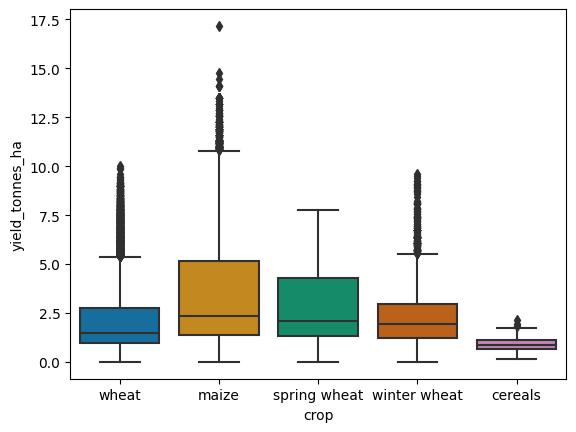

In [73]:
sns.boxplot(data=df, x='crop', y='yield_tonnes_ha', palette='colorblind')

<Axes: xlabel='crop', ylabel='production_tonnes'>

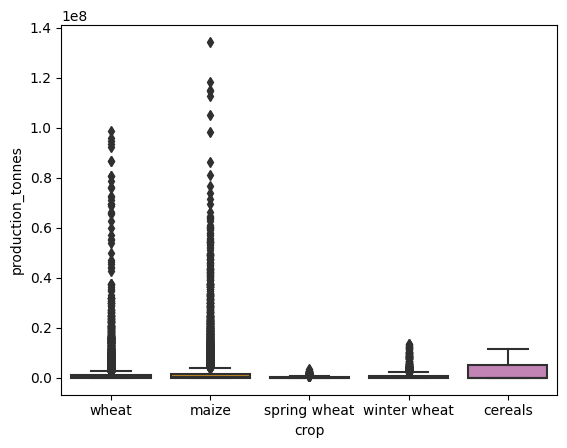

In [74]:
sns.boxplot(data=df, x='crop', y='production_tonnes', palette='colorblind')

<Axes: xlabel='crop', ylabel='hectares_ha'>

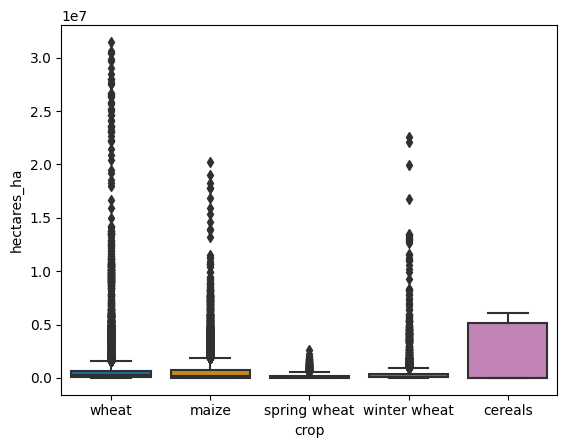

In [75]:
sns.boxplot(data=df, x='crop', y='hectares_ha', palette='colorblind')

We see everything is very right skewed, to the point that it is difficult to work with. Logarithmic transformations are the go to solution for that, so let's try that.

In [76]:
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])

<Axes: xlabel='crop', ylabel='log_yield'>

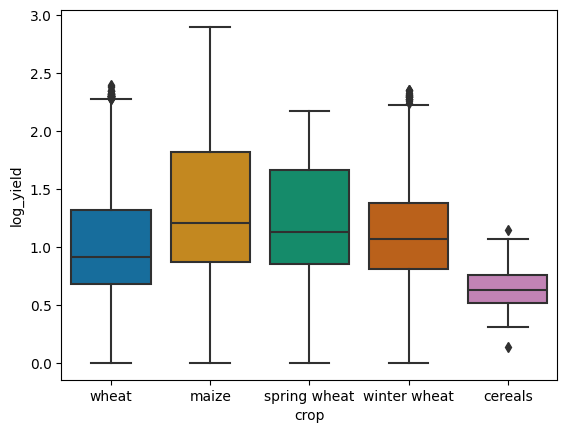

In [77]:
sns.boxplot(data=df, x='crop', y='log_yield', palette='colorblind')

<Axes: xlabel='crop', ylabel='log_hectares'>

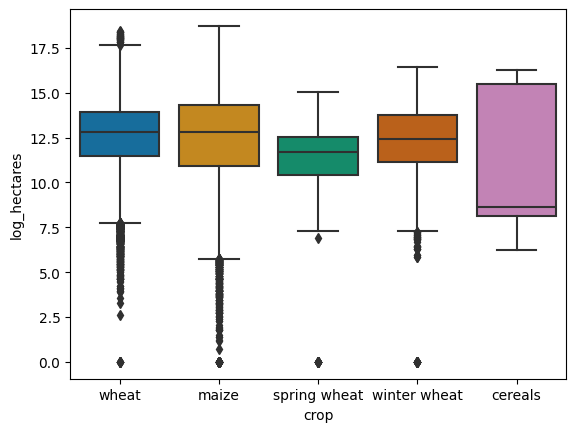

In [78]:
sns.boxplot(data=df, x='crop', y='log_hectares', palette='colorblind')

<Axes: xlabel='crop', ylabel='log_production'>

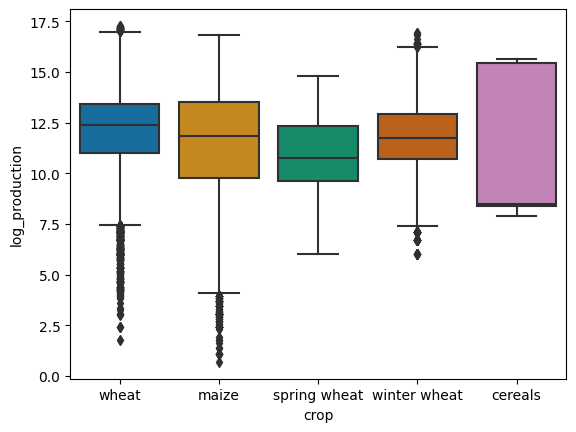

In [79]:
sns.boxplot(data=df, x='crop', y='log_production', palette='colorblind')

Much better, for now we will keep in the original columns as well because they might prove more valuable during the training of the models.
We have a lot to look at here, to make things more manageable in the time we have for this project we have decided to only focus on the crop with the most available data and on the five countries that have the highest yield for this crop over all time. Let's figure out what values we then get.

In [80]:
df.groupby('crop').count()

,national,subnational,hectares_ha,production_tonnes,year,yield_tonnes_ha,log_yield,log_hectares,log_production
crop,,,,,,,,,
cereals,80,80,80,80,80,80,80,80,80
maize,13191,13191,13191,13191,13191,13191,13191,13191,13191
spring wheat,718,718,718,718,718,718,718,718,718
wheat,15479,15479,15479,15479,15479,15479,15479,15479,15479
winter wheat,4687,4687,4687,4687,4687,4687,4687,4687,4687


We see that wheat has the most rows, with 15479 values, so we will go with that one.

In [81]:
df = df[df['crop'] == 'wheat']
df.groupby('subnational').agg({'yield_tonnes_ha': 'mean'}).nlargest(5, 'yield_tonnes_ha')

,yield_tonnes_ha
subnational,
Belgium,6.530132
Nord-Pas-de-Calais,4.570723
Austria,4.470356
Croatia,4.427806
Picardy,4.389738


In [82]:
df.groupby('national').agg({'yield_tonnes_ha': 'mean'}).nlargest(5, 'yield_tonnes_ha')

,yield_tonnes_ha
national,
Belgium,6.530132
Austria,4.470356
Croatia,4.427806
United Kingdom,4.208898
Czech Republic,4.200240


In [84]:
df.groupby('national')['log_yield'].count().sort_values(ascending=False)

national
United States     6256
France            2589
China             1688
Spain             1625
Australia          898
Italy              896
Brazil             294
United Kingdom     134
Mexico             121
Argentina          118
India              116
Canada             110
Uruguay            109
South Africa       101
Chile               88
Portugal            87
Belgium             57
Austria             57
Finland             57
Czech Republic      52
Croatia             26
Name: log_yield, dtype: int64

In [85]:
df.groupby('subnational')['log_yield'].count().sort_values(ascending=False)

subnational
ALABAMA                         153
MARYLAND                        153
GEORGIA                         153
ILLINOIS                        153
INDIANA                         153
                               ... 
NEW HAMPSHIRE                    34
Croatia                          26
CONNECTICUT                      22
Australian Capital Territory     20
Northern Territory                8
Name: log_yield, Length: 140, dtype: int64

For country size for the top five seems homogenous, so we will focus on that. Focussing on the national column makes the subnational column obsolete, so we can delete that one as well.

In [68]:
df = df[df['national'].isin(['Belgium', 'Austria', 'Croatia', 'United Kingdom', 'Czech Republic'])]
df.drop('subnational', axis=1, inplace=True)
df.info()

KeyError: "['subnational'] not found in axis"

## Exploratory Data Analysis

<Axes: >

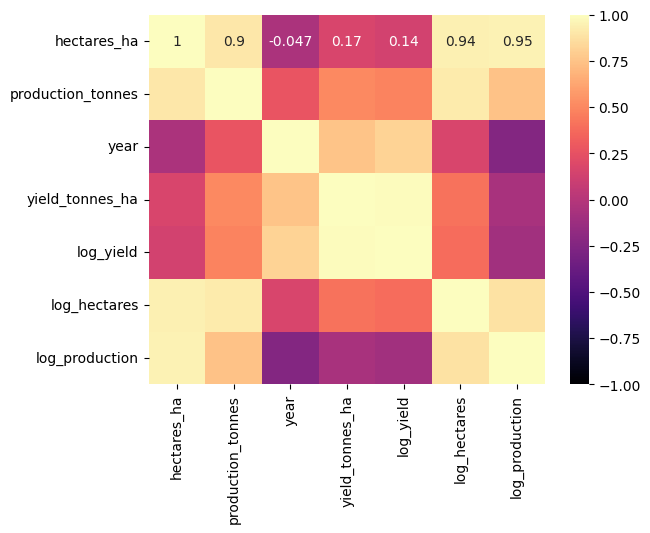

In [ ]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, cmap='magma', annot=True)

In [ ]:
corr['yield_tonnes_ha'].sort_values(ascending=False)

yield_tonnes_ha      1.000000
log_yield            0.985387
year                 0.751018
production_tonnes    0.507719
log_hectares         0.407196
hectares_ha          0.169849
log_production      -0.065974
Name: yield_tonnes_ha, dtype: float64

In [ ]:
corr['log_yield'].sort_values(ascending=False)

log_yield            1.000000
yield_tonnes_ha      0.985387
year                 0.819004
production_tonnes    0.483548
log_hectares         0.389285
hectares_ha          0.140537
log_production      -0.096204
Name: log_yield, dtype: float64

We see a lot of correlation in our dataset. We can obviously ignore the correlation between the columns with their corresponding logarithmic columns. We see high correlation between yield and year, as well as between yield and production and yield and log_hectares. It is interesting that there is much less correlation with hectares and log_production.

In [ ]:
df.groupby('national').count()

,crop,hectares_ha,production_tonnes,year,yield_tonnes_ha,log_yield,log_hectares,log_production
national,,,,,,,,
Austria,57,57,57,57,57,57,57,57
Belgium,57,57,57,57,57,57,57,57
Croatia,26,26,26,26,26,26,26,26
Czech Republic,52,52,52,52,52,52,52,52
United Kingdom,134,134,134,134,134,134,134,134


<Axes: xlabel='national', ylabel='log_yield'>

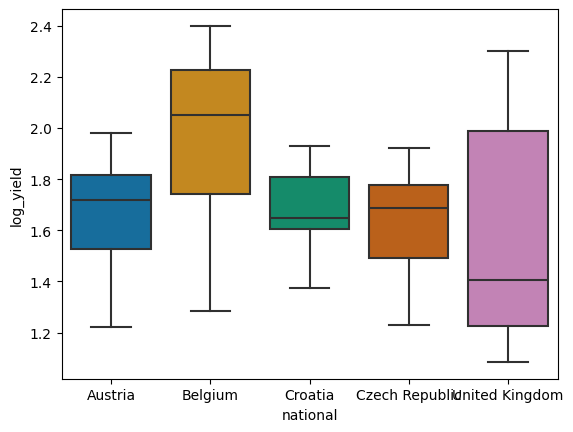

In [ ]:
sns.boxplot(data=df, x='national', y='log_yield', palette='colorblind')

<Axes: xlabel='year', ylabel='log_yield'>

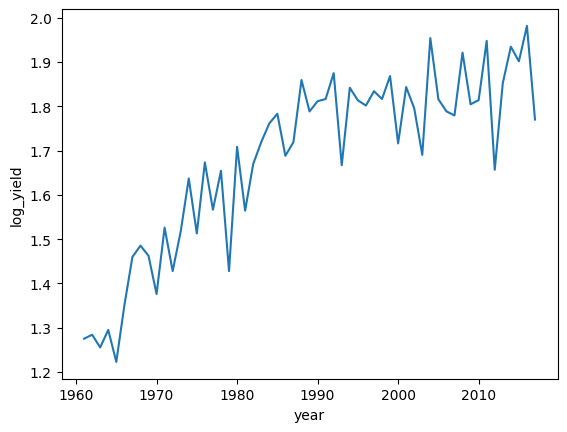

In [ ]:
filtered_data = df[df['national'] == 'Austria']
sns.lineplot(data=filtered_data, x='year', y='log_yield')

<Axes: xlabel='year', ylabel='log_yield'>

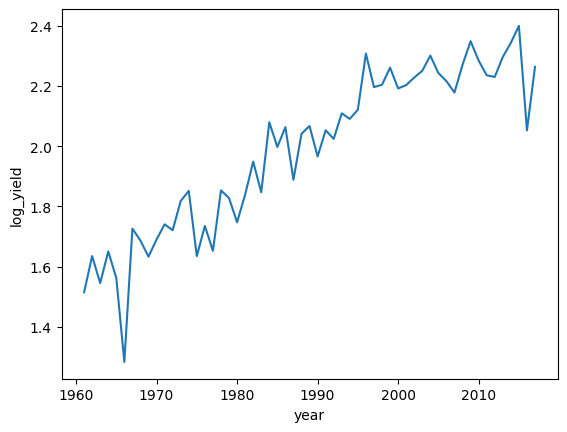

In [ ]:
filtered_data = df[df['national'] == 'Belgium']
sns.lineplot(data=filtered_data, x='year', y='log_yield')

<Axes: xlabel='year', ylabel='log_yield'>

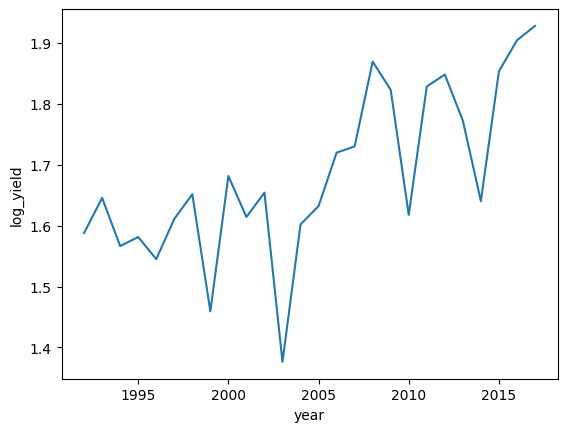

In [ ]:
filtered_data = df[df['national'] == 'Croatia']
sns.lineplot(data=filtered_data, x='year', y='log_yield')

<Axes: xlabel='year', ylabel='log_yield'>

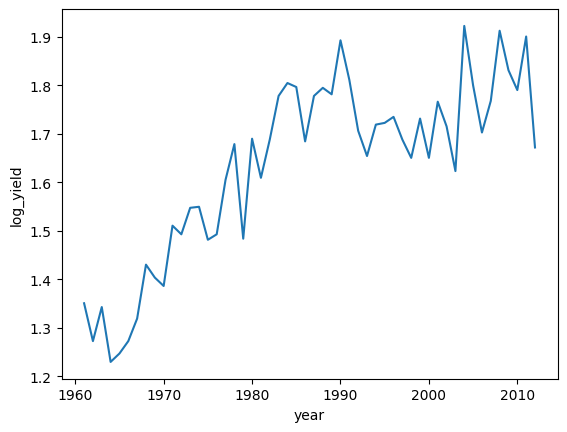

In [ ]:
filtered_data = df[df['national'] == 'Czech Republic']
sns.lineplot(data=filtered_data, x='year', y='log_yield')

<Axes: xlabel='year', ylabel='log_yield'>

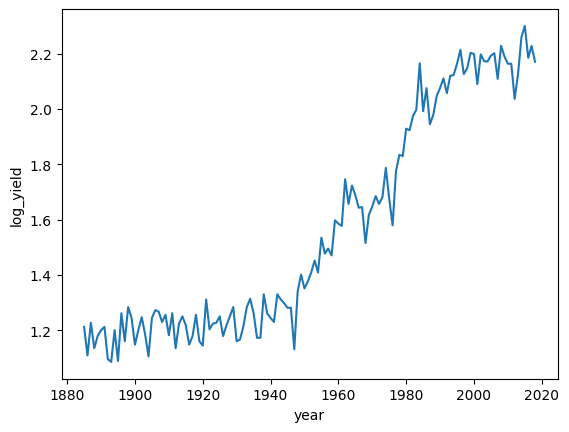

In [ ]:
filtered_data = df[df['national'] == 'United Kingdom']
sns.lineplot(data=filtered_data, x='year', y='log_yield')

In summary, during the training of the models the following things should be considered:
- Remove logarithmic or original columns for yield, production, and hectares.